In [1]:
import math

%matplotlib inline
from matplotlib import pyplot as plt

import gpytorch
import torch

In [2]:
train_x = torch.linspace(0, 2, 7)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.1

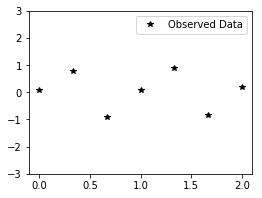

In [3]:
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data']);

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, batch_shape=torch.Size()):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(
            batch_shape=batch_shape,
        )
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(batch_shape=batch_shape),
            batch_shape=batch_shape
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, batch_shape=torch.Size())

# Here - we'll do some initializtion of the two period lengths
# so that our optimization finds two different modes
model.covar_module.base_kernel.initialize(period_length=torch.tensor(0.5))

PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)

In [6]:
model.train()
likelihood.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [7]:
def potential_fn(params):
    model.load_state_dict(params)
    output = model(train_x)
    return mll(output, train_y).sum()

In [8]:
z = model.state_dict()
z_keys, z_values = zip(*z.items())
for p in z_values:
    p.requires_grad_(True)
potential_energy = potential_fn(z)

In [9]:
torch.autograd.grad(potential_energy, z_values)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [21]:
list(model.named_parameters())

[('likelihood.noise_covar.raw_noise', Parameter containing:
  tensor([0.], requires_grad=True)),
 ('mean_module.constant', Parameter containing:
  tensor([0.], requires_grad=True)),
 ('covar_module.raw_outputscale', Parameter containing:
  tensor(0., requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
  tensor([[0.]], requires_grad=True)),
 ('covar_module.base_kernel.raw_period_length', Parameter containing:
  tensor([[-0.4328]], requires_grad=True))]

In [42]:
def _potential_grad(potential_fn, z):
    z_keys, z_nodes = zip(*z.items())
    for node in z_nodes:
        node.requires_grad_(True)
    potential_energy = potential_fn(z)
    grads = torch.autograd.grad(potential_energy, z_nodes)
    for node in z_nodes:
        node.requires_grad_(False)
    return dict(zip(z_keys, grads)), potential_energy

In [43]:
class Linear(torch.nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.a = torch.nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.a ** 2 * x

linear = Linear()

z = linear.state_dict()
params = {k: torch.nn.Parameter(v) for k, v in z.items()}

def f(z):
    linear.a = z["a"]
    return linear(torch.tensor(1.))

_potential_grad(f, params)

({'a': tensor(2.)}, tensor(1., grad_fn=<MulBackward0>))

In [11]:
from pyro.infer.mcmc import HMC, MCMC

hmc_kernel = HMC(model=None, potential_fn=potential_fn, jit_compile=False,
                 ignore_jit_warnings=True)
hmc_kernel.initial_params = model.state_dict()
mcmc_run = MCMC(hmc_kernel, num_samples=4000, warmup_steps=500).run()

Warmup:   0%|          | 0/4500 [00:00<?, ?it/s]

TypeError: bad operand type for unary -: 'NoneType'